In [1]:
from __future__ import print_function
from __future__ import print_function
from __future__ import print_function
from __future__ import print_function
from copy import deepcopy
import math
import os
import sys

import numpy as np
#from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.cross_validation import StratifiedShuffleSplit, StratifiedKFold

C:\Users\poorn\Anaconda3\envs\DL4Med\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# sys.path.append("..")
# from dataprocessing.util import make_splits

np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True)

def try_making_splits(y, nfold, test_ratio=None):
    '''
    y: n*n_class
        tries to find n splits, where:
        size of (train, valid, test) is (nfold-2, 1, 1)
        # of samples for one class is (>=1/2, >=0.5*ratio, >=0.5*ratio)
    '''
    idx_list = np.empty([nfold, 3], dtype=object)
    if test_ratio is None:
        test_ratio = 1.0 / nfold
    n_samples, n_classes = y.shape
    i_class_least = np.argmin(np.sum(y, axis=0))
    i_trial = 0
    print('\nnew try: ', i_trial,)
    cnt = 0
    while i_trial < nfold:
        cnt += 1
        if cnt % 1000 == 0:
            print('{} trials'.format(cnt))
        success_flag = True
        ss = StratifiedShuffleSplit(y[:, i_class_least], n_iter=1,
                                    test_size=test_ratio)
        for idx_trva, idx_te in ss:  # length is only 1 !
            for i_class in range(n_classes):
                te_percent = 1.0 * np.sum(y[idx_te, i_class]) / np.sum(y[:, i_class])
                trva_percent = 1.0 * np.sum(y[idx_trva, i_class]) / np.sum(y[:, i_class])
                if te_percent < 0.5 * test_ratio or \
                                trva_percent < 0.5 + 0.5 * test_ratio:
                    success_flag = False
                    break
            if not success_flag:
                break
        if not success_flag:
            continue
        cnt2 = 0
        while cnt2 < 1000:
            cnt2 += 1
            success_flag = True
            ss2 = StratifiedShuffleSplit(y[idx_trva, i_class_least], n_iter=1,
                                         test_size=test_ratio * n_samples / len(idx_trva))
            for idx_tr_ss2, idx_va_ss2 in ss2:  # length is only 1 !
                idx_tr = idx_trva[idx_tr_ss2]
                idx_va = idx_trva[idx_va_ss2]
                for i_class in range(n_classes):
                    tr_percent = 1.0 * np.sum(y[idx_tr, i_class]) / np.sum(y[:, i_class])
                    va_percent = 1.0 * np.sum(y[idx_va, i_class]) / np.sum(y[:, i_class])
                    if va_percent < 0.5 * test_ratio or \
                                    tr_percent < 0.5:
                        success_flag = False
                        break
                if not success_flag:
                    break
            if not success_flag:
                continue
        if not success_flag:
            continue
        idx_list[i_trial] = [idx_tr, idx_va, idx_te]
        i_trial += 1
    return idx_list


def make_splits(y, nfold):
    if len(y.shape) > 1 and y.shape[1] > 1:
        return try_making_splits(y, nfold)
    assert nfold > 2
    skf = StratifiedKFold(np.array(y).flatten(), nfold, shuffle=True, random_state=0)
    idx_trva_list = []
    idx_te_list = []
    for idx_tr, idx_te in skf:
        idx_trva_list.append(idx_tr)
        idx_te_list.append(idx_te)

    idx_list = np.empty([nfold, 3], dtype=object)
    for i in range(nfold):
        idx_list[i][0] = np.setdiff1d(idx_trva_list[i], idx_te_list[(i + 1) % nfold], True)
        idx_list[i][1] = idx_te_list[(i + 1) % nfold]
        idx_list[i][2] = idx_te_list[i]
    return idx_list

# def get_icd9_subcat_label(icd9_str):
#     ss = icd9_str.split('.')[0]
#     idx_lb = max(np.where(ss >= subcat_lbs)[0])
#     idx_ub = min(np.where(ss[:4] <= subcat_ubs)[0])
#     if idx_lb != idx_ub:
#         print(idx_lb, idx_ub, icd9_str, ss)
#     #assert idx_lb == idx_ub
#     return idx_lb

In [3]:
#### Main ####
# DATA_NAME = 'mimic319k48h'
# Settings for task, model, path, etc
# working_path = r'../..'
HRS = 48

working_path = '../../Data/admdata_17f/%dhrs/' % HRS
# raw_data_path = os.path.join(working_path, 'data', DATA_NAME, 'raw')
# processed_data_path = os.path.join(working_path, 'data', DATA_NAME)
raw_data_path = working_path
processed_data_path = os.path.join(working_path, 'series')
if not os.path.exists(processed_data_path):
    os.makedirs(processed_data_path)

LAB_EVENTS_IDX = np.array([0,1,2,3,4,5,7,8,9,10,11,12]) # labevents and chartevents

print('load data file')
data_all = np.empty([0], dtype=object)
for datanpz_file_name in ['DB_merged_%dhrs.npy' % HRS]:
    datanpz_file_pathname = os.path.join(raw_data_path,
                                         datanpz_file_name)
    data_all = np.concatenate((data_all, np.load(datanpz_file_pathname)))

print('load icd9 label file')
label_icd9_all = np.empty([0], dtype=object)
for label_icd9_npz_file_name in ['ICD9-%dhrs.npy' % HRS]:
    label_icd9_npz_file_pathname = os.path.join(raw_data_path, 
                                                label_icd9_npz_file_name)
    label_icd9_all = np.concatenate((label_icd9_all, 
                                    np.load(label_icd9_npz_file_pathname)))

# print('load icd9 subcat list file')
# subcat_lbs = []
# subcat_ubs = []
# with open(os.path.join(raw_data_path, 'ICD9_subcat.csv'), 'r') as f:
#     for line in f.readlines():
#         subcat_id, subcat_lb, subcat_ub = line.split(',')
#         subcat_lbs.append(subcat_lb)
#         subcat_ubs.append(subcat_ub)
#     subcat_lbs = np.array(subcat_lbs)
#     subcat_ubs = np.array(subcat_ubs)

print('load mor label file')
label_mor_all = None
for label_mor_npz_file_name in ['AGE_LOS_MORTALITY_%dhrs.npy' % HRS]:
    label_mor_npz_file_pathname = os.path.join(raw_data_path,
                                               label_mor_npz_file_name)
    if label_mor_all is None:
        label_mor_all = np.load(label_mor_npz_file_pathname)
    else:
        label_mor_all = np.concatenate((label_mor_all, 
                                        np.load(label_mor_npz_file_pathname)))
        
print('load admission features')
adm_features_all = np.load(os.path.join(raw_data_path, 'ADM_FEATURES_%dhrs.npy' % HRS))

print('load mortality labels')
adm_labels_all = np.load(os.path.join(raw_data_path, 'ADM_LABELS_%dhrs.npy' % HRS))

N_all = len(data_all)
print('# of samples:', N_all)
# get per-frame samples;
# imputed-normed-ep (imputation here):    
#               ep_tdata_raw, ep_tdata: N * [ti * D]
#               ep_tdata_mean, ep_tdata_std: D
# normed-ep:    X_t, X_t_mask, deltaT_t: N * [ti * D]
#               T_t: N * [ti]
X_raw_p48 = np.array([np.array(xx, dtype=float)[:,:-2] for xx in data_all])
tsraw_p48 = np.array([np.array(xx, dtype=float)[:,-2] for xx in data_all])
del data_all

idx_x = np.where([(tt[-1] - tt[0]) > 1.0*60*60*HRS for tt in tsraw_p48])[0]
idx_x2 = np.where([(tt[-1] - tt[0]) <= 1.0*60*60*HRS for tt in tsraw_p48])[0]
print(idx_x2)
N = len(idx_x)
print('# of samples > %s hours:' % (HRS), N)
assert N_all == N
X_raw = X_raw_p48[idx_x]
tsraw = tsraw_p48[idx_x]
label_icd9_all = label_icd9_all[idx_x]
label_mor_all = label_mor_all[idx_x]
adm_features_all = adm_features_all[idx_x]
adm_labels_all = adm_labels_all[idx_x]

for i_n in range(N):
    #print i_n
    if i_n % 20 == 0:
        print('.', end='')
        sys.stdout.flush()
    for i_t in range(len(X_raw[i_n])):
        for i_d in range(len(X_raw[i_n][i_t])):
            if X_raw[i_n][i_t][i_d] is None:
                X_raw[i_n][i_t][i_d] = np.nan
X_raw_all = np.concatenate(X_raw)
print('done!')

load data file
load icd9 label file
load mor label file
load admission features
load mortality labels
# of samples: 32290
[]
# of samples > 48 hours: 32290
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [4]:
print(tsraw_p48)

[array([   517.,    757.,   1057.,   1357.,   1657.,   1957.,   2257.,
         2557.,   3457.,   6157.,   9757.,  10657.,  13357.,  16957.,
        20557.,  24157.,  27757.,  31357.,  34957.,  38557.,  42157.,
        45757.,  49357.,  52957.,  56557.,  59257.,  60157.,  63757.,
        67357.,  70957.,  74557.,  78157.,  79057.,  81757.,  83557.,
        85357.,  87157.,  88957.,  92557.,  96157.,  99757., 100657.,
       101557., 103357., 106957., 110557., 158257., 184957., 185557.,
       193357., 194257., 195157., 196957., 198757., 199357., 200557.,
       205957., 207757., 211357., 214957., 218557., 222157., 225757.,
       229357., 232957., 235957., 236557., 240157., 243757., 247357.,
       250957., 252757., 258157., 265357., 270757., 276157., 279757.,
       285157., 294157., 297757., 301357., 308557., 315517., 315757.,
       322957., 330157., 337357., 344557., 345457., 349957., 351757.,
       420757., 505357.])
 array([  7229.,  15869.,  18329.,  21089.,  21329.,  25889.,  

In [5]:
# remove the columns with less observations
print('get mr and kept idx')
val_mr = np.sum(np.isnan(X_raw_all), axis=0) * 1.0 / X_raw_all.shape[0]
keep_val_idx = val_mr < 1-5e-4
keep_val_idx_list = np.where(keep_val_idx)
X_raw_all_kept = X_raw_all[:,keep_val_idx]
X_raw_kept = np.array([xx[:, keep_val_idx] for xx in X_raw])
lab_events_idx = LAB_EVENTS_IDX

del X_raw_all
del X_raw

# X_raw_all_

get mr and kept idx


In [6]:
# Get the mean value in the first HRS hours, used for SuperLearner
# First get the mean of pao2 and fio2, then calc the ratio!!!
PAO2_VAR = 4
FIO2_VAR = 5
RATIO_VAR = 4

In [7]:
print('get mean and std for tdata')
n_temporal_var = X_raw_all_kept.shape[1]    # last frame is time t in seconds
ep_tdata_mean = np.nanmean(X_raw_all_kept, axis=0)
ep_tdata_std = np.nanstd(X_raw_all_kept, axis=0)
del X_raw_all_kept

# get ep data with mask and deltaT
# 0-mean, 1-std, merge observations within 5 mins
merging_mins = 5
print('get X_new and t_new')
X_new = np.empty([N], dtype=object)
t_new = np.empty([N], dtype=object)
for i in range(N):
    if i % 20 == 0:
        print('.',end='')
        sys.stdout.flush()
    tsraw[i] = tsraw[i].flatten()
    t = 0
    X_new[i] = []
    t_new[i] = []
    while t < len(tsraw[i]):
        t1 = t+1
        while t1 < len(tsraw[i]) and tsraw[i][t1] - tsraw[i][t] <= merging_mins*60:
            t1 += 1
        # merge [t:t1]
#         X_new[i].append(
#             (np.nanmean(X_raw_kept[i][t:t1,:], axis=0) - ep_tdata_mean) \
#                 /ep_tdata_std
#             )
        # Here we do not normalize the data!!!
        X_new[i].append(
            np.nanmean(X_raw_kept[i][t:t1,:], axis=0)
            )
        # X_new[i].append(np.nanmean(X_raw_kept[i][t:t1,:], axis=0))
        t_new[i].append(int((tsraw[i][t1-1]+tsraw[i][t])/2))
        t = t1
print('done!')

get mean and std for tdata
get X_new and t_new
..

C:\Users\poorn\Anaconda3\envs\DL4Med\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [8]:
print('get X_t, mask, etc')
X_t = np.empty([N], dtype=object)        # N * [t*d]
X_t_mask = np.empty([N], dtype=object)   # N * [t*d]
T_t = t_new                                 # N * [t]
deltaT_t = np.empty([N], dtype=object)   # N * [t*d]
for i in range(N):
    if i % 20 == 0:
        print('.',end='')
        sys.stdout.flush()
    X_t[i] = np.vstack(X_new[i])
    X_t_mask[i] = 1-np.isnan(X_t[i]).astype('int8')
    X_t[i][np.isnan(X_t[i])] = 0
    deltaT_t[i] = np.zeros_like(X_t[i], dtype=int)
    deltaT_t[i][0,:] = 0
    for i_t in range(1, len(T_t[i])):
        deltaT_t[i][i_t,:] = T_t[i][i_t] - T_t[i][i_t-1] + \
            (1-X_t_mask[i][i_t-1,:]) * deltaT_t[i][i_t-1,:]
print('done!')
del X_new

get X_t, mask, etc
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [9]:
# extract subcat labels
# for i_n, label_i in enumerate(label_icd9_all):
#     for i_li, label_vec in enumerate(label_i):
#         subcat = get_icd9_subcat_label(label_vct[2])
#         label_i[i_li].append(subcat)
#     label_icd9_all[i_n] = label_i
        
# get labels
print('get labels')
class_icd9_counts = np.bincount(
    np.concatenate(label_icd9_all)[:,3].astype(int))
class_icd9_list = np.where(class_icd9_counts > 10)[0]
class_icd9_list.sort()

# class_icd9_subcat_counts = np.bincount(
#     np.concatenate(label_icd9_all)[:,4].astype(int))
# class_icd9_subcat_list = np.where(class_icd9_subcat_counts >= 200)[0]
# class_icd9_subcat_list.sort()

n_class_icd9 = class_icd9_list.shape[0]
# n_class_icd9_subcat = class_icd9_subcat_list.shape[0]
y_icd9 = np.zeros([N, n_class_icd9], dtype=int)
# y_icd9_subcat = np.zeros([N, n_class_icd9_subcat], dtype=int)
for i_n, label_i in enumerate(label_icd9_all):
        for label_vec in label_i:
            class_idx = np.array(
                [cl == label_vec[3] for cl in class_icd9_list],
                dtype=bool)
            y_icd9[i_n][class_idx] = 1
#             subcat_idx = np.array(
#                 [cl == label_vec[4] for cl in class_icd9_subcat_list],
#                 dtype=bool)
#             y_icd9_subcat[i_n][subcat_idx] = 1

y_mor = np.expand_dims(np.array(label_mor_all[:,4], dtype=int), axis=1)
age_days = label_mor_all[:, 2]
y_los = label_mor_all[:, 3]
            
# print('# of class, subcat:', n_class_icd9, n_class_icd9_subcat)
print('# of class, subcat:')

np.savez(os.path.join(processed_data_path, 'normed-ep-stats.npz'), 
         class_icd9_list=class_icd9_list, 
         class_icd9_counts=class_icd9_counts,
#          class_icd9_subcat_list=class_icd9_subcat_list,
#          class_icd9_subcat_counts=class_icd9_subcat_counts,
         keep_val_idx_list=keep_val_idx_list, 
         ep_tdata_mean=ep_tdata_mean, ep_tdata_std=ep_tdata_std,
         n_class_icd9=n_class_icd9, 
#          n_class_icd9_subcat=n_class_icd9_subcat,
         N=N, val_mr=val_mr, idx_x=idx_x, age_days=age_days)

np.savez(os.path.join(processed_data_path, 'normed-ep.npz'), 
         X_t=X_t,X_t_mask=X_t_mask,T_t=T_t,deltaT_t=deltaT_t,
         y_icd9=y_icd9, y_mor=y_mor, adm_features_all=adm_features_all, adm_labels_all=adm_labels_all,y_los=y_los)
# , y_icd9_subcat=y_icd9_subcat)

del X_t, X_t_mask, deltaT_t

get labels
# of class, subcat:


In [10]:
ep_origin = np.load(os.path.join(processed_data_path, 'normed-ep.npz'))
# Here we merge pao2 and fio2 and get pf ratio
X_t_ratio = []
X_t_ratio_mask = []
T_t_ratio = []
deltaT_t_ratio = []
X_t_origin, X_t_origin_mask, T_t_origin, deltaT_t_origin = ep_origin['X_t'], ep_origin['X_t_mask'], ep_origin['T_t'], ep_origin['deltaT_t']
for t in range(X_t_origin.shape[0]):
    if t % 20 == 0:
        print('.', end='')
    xto = X_t_origin[t]
    xtom = X_t_origin_mask[t]
    tto = T_t_origin[t]
    dto = deltaT_t_origin[t]
    ratio_shape = (xto.shape[0], xto.shape[1] - 1)
    xto_ratio = np.full(ratio_shape, np.nan)
    xtom_ratio = np.full(ratio_shape, np.nan)
    tto_ratio = tto
    dto_ratio = np.full(ratio_shape, np.nan)
    # keep others
    for itratio, it in zip([xto_ratio, xtom_ratio, dto_ratio],[xto, xtom, dto]):
        itratio[:, :PAO2_VAR] = it[:, :PAO2_VAR]
        itratio[:, FIO2_VAR:] = it[:, FIO2_VAR + 1:]
    # fix the ratio part
    xto_ratio[:, PAO2_VAR] = xto[:, PAO2_VAR] / xto[:, FIO2_VAR]
    xto_ratio[np.isinf(xto_ratio)] = np.nan
    xtom_ratio[:, PAO2_VAR] = np.logical_and(xtom[:, PAO2_VAR], xtom[:, FIO2_VAR])
    dto_ratio[:, PAO2_VAR] = np.zeros_like(dto[:, PAO2_VAR])
    for i_t in range(1, len(tto_ratio)):
        dto_ratio[i_t,PAO2_VAR] = tto_ratio[i_t] - tto_ratio[i_t-1] + \
            (1-xtom_ratio[i_t-1,PAO2_VAR]) * dto_ratio[i_t-1,PAO2_VAR]
    X_t_ratio.append(xto_ratio)
    X_t_ratio_mask.append(xtom_ratio)
    T_t_ratio.append(tto_ratio)
    deltaT_t_ratio.append(dto_ratio)
X_t_ratio = np.array(X_t_ratio, dtype=object)
X_t_ratio_mask = np.array(X_t_ratio_mask, dtype=object)
T_t_ratio = np.array(T_t_ratio, dtype=object)
deltaT_t_ratio = np.array(deltaT_t_ratio, dtype=object)
np.savez(os.path.join(processed_data_path, 'normed-ep-ratio.npz'), 
         X_t=X_t_ratio,X_t_mask=X_t_ratio_mask,T_t=T_t_ratio,deltaT_t=deltaT_t_ratio,
         y_icd9=ep_origin['y_icd9'], y_mor=ep_origin['y_mor'], adm_features_all=ep_origin['adm_features_all'], adm_labels_all=ep_origin['adm_labels_all'])

...........

C:\Users\poorn\Anaconda3\envs\DL4Med\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\poorn\Anaconda3\envs\DL4Med\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [11]:
# get first N hours data
# one data sample for one patient
# hours_list = [(2, 24), (1, 24), (1, 48), (2, 48)]
hours_list = [(2, HRS), (1, HRS)]
for n_sample_hour, n_full_hour in hours_list:
    print('get X_miss', n_sample_hour, n_full_hour)
    #n_sample_hour = 2
    #n_full_hour = HRS
    n_time_step = int(n_full_hour / n_sample_hour)
    # get X_miss first from X_raw_all_kept and tsraw, (sampled)
    X_miss = np.empty([N], dtype = object)
    T_miss = np.zeros([N], dtype = int)
    for i_n in range(N):
        if i_n % 20 == 0:
            print('.',end='')
            sys.stdout.flush()
        T_miss[i_n] = math.ceil(
            (tsraw[i_n][-1]-tsraw[i_n][0])*1.0/(60*60*n_sample_hour))
        X_miss[i_n] = np.zeros([T_miss[i_n], n_temporal_var], dtype=float)
        for i_t in range(T_miss[i_n]):
            t_idx = np.logical_and(
                (tsraw[i_n]-tsraw[i_n][0]) >= i_t*(60*60*n_sample_hour),
                (tsraw[i_n]-tsraw[i_n][0]) <= (1+i_t) * (60*60*n_sample_hour))
            X_raw_thist = X_raw_kept[i_n][t_idx, :]
            # Here we do not normalize the data!!!
#             X_miss[i_n][i_t,:] = \
#                 (np.nanmean(X_raw_thist, axis=0) - ep_tdata_mean) / ep_tdata_std
            X_miss[i_n][i_t,:] = np.nanmean(X_raw_thist, axis=0)
    print('done!')
    # X_imputed: do forward/backward imputing from X_miss for lab events
    #            do mean imputing for other events
    print('get X_imputed')
    X_imputed = deepcopy(X_miss)
    for i_n in range(N):
        if i_n % 20 == 0:
            print('.',end='')
            sys.stdout.flush()
        i_n_mean = np.nanmean(X_imputed[i_n], axis=0)
        for i_t in range(1, T_miss[i_n]):
            for i_d in range(n_temporal_var):
                if np.isnan(X_imputed[i_n][i_t, i_d]):
                    if keep_val_idx_list[0][i_d] in lab_events_idx:
                        X_imputed[i_n][i_t, i_d] = X_imputed[i_n][i_t-1, i_d]
        for i_t in range(T_miss[i_n]-2, -1, -1):
            for i_d in range(n_temporal_var):
                if np.isnan(X_imputed[i_n][i_t, i_d]):
                    if keep_val_idx_list[0][i_d] in lab_events_idx:
                        X_imputed[i_n][i_t, i_d] = X_imputed[i_n][i_t+1, i_d]
        # X_imputed[i_n][np.isnan(X_imputed[i_n])] = 0
        # Here we use mean value of each feature in current time series to impute nans
        for i_t in range(0, T_miss[i_n]):
            for i_d in range(n_temporal_var):
                if np.isnan(X_imputed[i_n][i_t, i_d]):
                    X_imputed[i_n][i_t, i_d] = i_n_mean[i_d]
        # for values which are still none, just impute with 0
#         X_imputed[i_n][np.isnan(X_imputed[i_n])] = 0
    print('done!')
        
    # get first # hours, for both data and masking
    print('get ep_tdata')
    ep_tdata = np.zeros([N, n_time_step, n_temporal_var], dtype=float)
    ep_tdata_masking = np.zeros_like(ep_tdata, dtype=int)
    for i_n in range(N):
        if i_n % 20 == 0:
            print('.',end='')
            sys.stdout.flush()
        xx_imp = X_imputed[i_n]
        xx_mis = X_miss[i_n]
        tt_min = min(n_time_step, len(xx_imp))
        assert tt_min > 0
        ep_tdata[i_n, :tt_min, :] = xx_imp[:tt_min, :]
        ep_tdata[i_n, tt_min:, :] = ep_tdata[i_n, tt_min-1, :][None, :]
        ep_tdata_masking[i_n, :tt_min, :] = \
            (~np.isnan(xx_mis[:tt_min, :])).astype(int)
    print('done!')
    
    # After imputation, calc the pf ratio!!!
    print('calculating pao2/fio2 ratio...')
    ep_tdata_withr = np.zeros([N, n_time_step, n_temporal_var - 1], dtype=float)
    ep_tdata_masking_withr = np.zeros_like(ep_tdata_withr, dtype=int)
    for i_n in range(N):
        if i_n % 20 == 0:
            print('.',end='')
            sys.stdout.flush()
        pfratio = ep_tdata[i_n, :, PAO2_VAR] / ep_tdata[i_n, :, FIO2_VAR]
        pfratio_masking = np.logical_and(ep_tdata_masking[i_n, :, PAO2_VAR] == 1,
                                        ep_tdata_masking[i_n, :, FIO2_VAR] == 1).astype(int)
        ep_tdata_withr[i_n, :, :PAO2_VAR] = ep_tdata[i_n, :, :PAO2_VAR]
        ep_tdata_withr[i_n, :, PAO2_VAR] = pfratio
        ep_tdata_withr[i_n, :, FIO2_VAR:] = ep_tdata[i_n, :, FIO2_VAR + 1:]
        ep_tdata_masking_withr[i_n, :, :PAO2_VAR] = ep_tdata_masking[i_n, :, :PAO2_VAR]
        ep_tdata_masking_withr[i_n, :, PAO2_VAR] = pfratio_masking
        ep_tdata_masking_withr[i_n, :, FIO2_VAR:] = ep_tdata_masking[i_n, :, FIO2_VAR + 1:]
    ep_tdata_withr[np.isinf(ep_tdata_withr)] = np.nan
#     ep_tdata_masking_withr[np.isnan(ep_tdata_withr)] = 0
    print('done!')
    
    # After calc ratio, impute the ratio!!!
    print('imputing pao2/fio2 ratio...')
    print('get X_withr_imputed')
    for i_n in range(N):
        if i_n % 20 == 0:
            print('.',end='')
            sys.stdout.flush()
        i_n_mean = np.nanmean(ep_tdata_withr[i_n], axis=0)
        tslen = ep_tdata_withr[i_n].shape[0]
        for i_t in range(1, tslen):
            for i_d in [PAO2_VAR]:
                if np.isnan(ep_tdata_withr[i_n, i_t, i_d]):
                    ep_tdata_withr[i_n, i_t, i_d] = ep_tdata_withr[i_n, i_t - 1, i_d]
        for i_t in range(tslen-2, -1, -1):
            for i_d in [PAO2_VAR]:
                if np.isnan(X_imputed[i_n][i_t, i_d]):
                    ep_tdata_withr[i_n, i_t, i_d] = ep_tdata_withr[i_n, i_t+1, i_d]
        # X_imputed[i_n][np.isnan(X_imputed[i_n])] = 0
        # Here we use mean value of each feature in current time series to impute nans
        for i_t in range(0, tslen):
            for i_d in [PAO2_VAR]:
                if np.isnan(ep_tdata_withr[i_n, i_t, i_d]):
                    ep_tdata_withr[i_n, i_t, i_d] = i_n_mean[i_d]
    # for values which are still none, just impute with 0
#     ep_tdata_withr[np.isnan(ep_tdata_withr)] = 0
    print('done!')
    
#     assert ep_tdata_withr[np.isnan(ep_tdata_withr)].shape == (0,)
    
    n_temporal_var_withr = n_temporal_var - 1
    ep_data_withr = np.reshape(ep_tdata_withr, [N, n_time_step*n_temporal_var_withr])
    ep_data_masking_withr = np.reshape(ep_tdata_masking_withr, [N, n_time_step*n_temporal_var_withr])
    
    np.savez(os.path.join(processed_data_path, 
                          'imputed-normed-ep' + '_' + str(n_sample_hour) + \
                          '_' + str(n_full_hour) + '.npz'), 
             ep_data = ep_data_withr, ep_tdata = ep_tdata_withr,
             ep_data_masking = ep_data_masking_withr, 
             ep_tdata_masking = ep_tdata_masking_withr,
             y_icd9 = y_icd9, y_mor = y_mor,adm_features_all=adm_features_all, adm_labels_all=adm_labels_all,y_los=y_los)
#     , y_icd9_subcat=y_icd9_subcat)

get X_miss 2 48
..

C:\Users\poorn\Anaconda3\envs\DL4Med\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

C:\Users\poorn\Anaconda3\envs\DL4Med\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [12]:
print(np.mean(y_mor))

0.10433570764942707


In [13]:
# imputed_data = np.load('../../Data/admdata_17f/24hrs_raw/series/imputed-normed-ep_1_24.npz')
# y_icd9 = imputed_data['y_icd9']
# adm_labels_all = imputed_data['adm_labels_all']

print('make splits')
# make 5-fold cv splits if file not exists
def make_splits_on(y_mor, foldn):
    folds_ep_mor = []
    for i in range(1):
        folds_ep_mor.append(make_splits(y_mor, foldn))
    return folds_ep_mor

def gen_folds_ids(foldn, fold_file_path, **kwargs):
    # generate folds based on label sets
    folds = {}
    print(list(kwargs.items()))
    for labelname, (labelarray, is_multi_task) in kwargs.items():
        assert len(labelarray.shape) > 1
        folds[labelname] = []
        if is_multi_task:
            for ln in range(labelarray.shape[1]):
                tempy = labelarray[:, ln]
                try:
                    lnfold = make_splits_on(tempy, foldn)
                except:
                    print('pass {0} {1}'.format(labelname, ln))
                    lnfold = None
                folds[labelname].append(lnfold)
        else:
            folds[labelname].append(make_splits_on(labelarray, foldn))
    np.savez(fold_file_path, **folds)
    return folds

def get_standardize_stats_for_training(ep_tdata, ep_tdata_masking, adm_features_all, training_ids):
    trainset = ep_tdata[training_ids]
    trainset_masking = ep_tdata_masking[training_ids]
    train_admfeatures = adm_features_all[training_ids]
    id_num = trainset.shape[0]
    dim = trainset.shape[2]
    stats = np.empty((dim, 2)) * np.nan
    for d in range(dim):
        dim_values = trainset[:,:,d].flatten()
        dim_mean = np.nanmean(dim_values)
        dim_std = np.nanstd(dim_values)
        stats[d,:] = np.array([dim_mean, dim_std])
    nsdim = adm_features_all.shape[1]
    nsstats = np.empty((nsdim, 2)) * np.nan
    for d in range(nsdim):
        dim_values = train_admfeatures[:, d].flatten()
        dim_mean = np.nanmean(dim_values)
        dim_std = np.nanstd(dim_values)
        nsstats[d,:] = np.array([dim_mean, dim_std])
    return stats, nsstats

def get_standardize_stats_for_training_missing(ep_tdata, ep_tdata_masking, adm_features_all, training_ids):
    trainset = np.concatenate(ep_tdata[training_ids])
    trainset_masking = np.concatenate(ep_tdata_masking[training_ids])
    train_admfeatures = adm_features_all[training_ids]
    id_num = trainset.shape[0]
    dim = trainset.shape[1]
    stats = np.empty((dim, 2)) * np.nan
    for d in range(dim):
        dim_masking = trainset_masking[:,d].flatten()
        dim_values = trainset[:,d].flatten()[np.where(dim_masking==1)]
        dim_mean = np.nanmean(dim_values)
        dim_std = np.nanstd(dim_values)
        stats[d,:] = np.array([dim_mean, dim_std])
    nsdim = adm_features_all.shape[1]
    nsstats = np.empty((nsdim, 2)) * np.nan
    for d in range(nsdim):
        dim_values = train_admfeatures[:, d].flatten()
        dim_mean = np.nanmean(dim_values)
        dim_std = np.nanstd(dim_values)
        nsstats[d,:] = np.array([dim_mean, dim_std])
    return stats, nsstats

def get_standardize_stats_for_folds(folds, stdfunc, ep_tdata, ep_tdata_masking, adm_features_all):
    statsdict = {}
    for key, value in folds.items():
        statsdict[key] = []
        for folds_ids in value:
            foldsstat = []
            for folds_ep_mor in folds_ids:
                foldsn = folds_ep_mor.shape[0]
                stats = []
                ep_tdata_stdized_list = []
                for foldn in range(foldsn):
                    training_ids = folds_ep_mor[foldn,0]
                    stat, nsstat = stdfunc(ep_tdata=ep_tdata, ep_tdata_masking=ep_tdata_masking, adm_features_all=adm_features_all, training_ids=training_ids)
                    fstat = [stat[:, 0], stat[:, 1]]
                    fnsstat = [nsstat[:, 0], nsstat[:, 1]]
                    stats.append([fstat, fnsstat])
                foldsstat.append(np.array(stats))
            statsdict[key].append(foldsstat)
    return statsdict

def split_dataset(datasetfilename, ep_tdata_attr, ep_tdata_masking_attr, ep_adm_features_all_attr, aidwhere, statfunc, foldn, fold_filedir, **kwargs):
    dataset = np.load(os.path.join(processed_data_path, datasetfilename + '.npz'))
    subdataset = {}
    for key, value in dataset.items():
        subdataset[key] = value[aidwhere]
    sub_tdata = subdataset[ep_tdata_attr]
    sub_masking = subdataset[ep_tdata_masking_attr]
    sub_label_all = subdataset[ep_adm_features_all_attr]
    sublabelset = {}
    for key, (value, is_multi_task) in kwargs.items():
        sublabelset[key] = (value[aidwhere], is_multi_task)
    if not os.path.exists(fold_filedir):
        os.makedirs(fold_filedir)
    fold_file_path = os.path.join(fold_filedir, '%d-folds.npz' % foldn)
    folds = gen_folds_ids(foldn=foldn, fold_file_path=fold_file_path, **sublabelset)
    statsdict = get_standardize_stats_for_folds(folds, statfunc, ep_tdata=sub_tdata, ep_tdata_masking=sub_masking, adm_features_all=sub_label_all)
    np.savez(os.path.join(fold_filedir, datasetfilename+'-stdized.npz'), **statsdict)
#     if not os.path.exists(os.path.join(fold_filedir, datasetfilename+'.npz')):
    np.savez(os.path.join(fold_filedir, datasetfilename+'.npz'), **subdataset)
    print('finish', fold_filedir)

from utils import getConnection

# select ids in carevue
sql = 'select distinct hadm_id from mimiciii.icustays where dbsource = \'metavision\' '
sql += 'UNION select distinct hadm_id from mimiciii.transfers where dbsource = \'metavision\''
conn = getConnection()
cur = conn.cursor()
cur.execute(sql)
res = cur.fetchall()
mvaids = sorted([r[0] for r in res])
mvaidset = set(mvaids)

MVDIR = os.path.join(processed_data_path, 'mv')
CVDIR = os.path.join(processed_data_path, 'cv')
ALLDIR = processed_data_path
data_all = np.load(os.path.join(working_path, 'DB_merged_%dhrs.npy' % HRS))
allaids = np.array([t[0][-1] for t in data_all])
mvwhere = np.array([aid in mvaidset for aid in allaids])
cvwhere = ~mvwhere
allwhere = np.logical_or(mvwhere, cvwhere)
assert np.alltrue(allwhere)

file_list = ['imputed-normed-ep_1_%d'%HRS, 'imputed-normed-ep_2_%d'%HRS]
for filename in file_list:
    for ids, dirname in zip([mvwhere, cvwhere, allwhere], [MVDIR, CVDIR, ALLDIR]):
        split_dataset(
            datasetfilename=filename,
            ep_tdata_attr='ep_tdata',
            ep_tdata_masking_attr='ep_tdata_masking',
            ep_adm_features_all_attr='adm_features_all',
            aidwhere=ids,
            statfunc=get_standardize_stats_for_training,
            foldn=5,
            fold_filedir=dirname,
            folds_ep_icd9=(y_icd9, True),
            folds_ep_icd9_multi=(y_icd9, False),
            folds_ep_mor=(adm_labels_all, True)
        )
        
ep_datafilename = 'normed-ep-ratio'
for ids, dirname in zip([mvwhere, cvwhere, allwhere], [MVDIR, CVDIR, ALLDIR]):
    split_dataset(
        datasetfilename=ep_datafilename,
        ep_tdata_attr='X_t',
        ep_tdata_masking_attr='X_t_mask',
        ep_adm_features_all_attr='adm_features_all',
        aidwhere=ids,
        statfunc=get_standardize_stats_for_training_missing,
        foldn=5,
        fold_filedir=dirname,
        folds_ep_icd9=(y_icd9, True),
        folds_ep_icd9_multi=(y_icd9, False),
        folds_ep_mor=(adm_labels_all, True)
    )

make splits
[('folds_ep_icd9', (array([[0, 0, 1, ..., 1, 1, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 1, 0]]), True)), ('folds_ep_icd9_multi', (array([[0, 0, 1, ..., 1, 1, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 1, 0]]), False)), ('folds_ep_mor', (array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]]), True))]

new try:  0


C:\Users\poorn\Anaconda3\envs\DL4Med\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


finish ../../Data/admdata_17f/48hrs/series\mv
[('folds_ep_icd9', (array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 1, 1]]), True)), ('folds_ep_icd9_multi', (array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 1, 1]]), False)), ('folds_ep_mor', (array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]]), True))]

new try:  0
finish ../../Data/admdata_17f/48hrs/series\cv
[('folds_ep_icd9', (array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 1, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 1,

[0.78947368 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368
 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368
 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368
 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368
 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368
 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368
 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368
 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368]


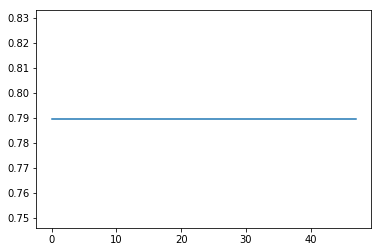

In [14]:
# check some plot
k = 4

# pao2 / fio2
checkx = np.load(os.path.join(processed_data_path, 'imputed-normed-ep_1_%d.npz'%HRS))['ep_tdata']
checkidx = np.random.randint(checkx.shape[0])
heart_rate = checkx[checkidx, :, k]
print(heart_rate)

import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(heart_rate)

In [15]:
checkx

array([[[ 15.        , 156.375     ,  67.75      , ..., 140.        ,
           4.1       ,          nan],
        [ 15.        , 145.        ,  73.        , ..., 140.        ,
           4.1       ,          nan],
        [ 15.        , 149.        ,  93.        , ..., 140.        ,
           4.1       ,          nan],
        ...,
        [ 15.        , 129.        ,  65.        , ..., 136.        ,
           4.3       ,          nan],
        [ 15.        , 129.        ,  65.        , ..., 136.        ,
           4.3       ,          nan],
        [ 15.        , 129.        ,  65.        , ..., 136.        ,
           4.3       ,          nan]],

       [[ 15.        , 120.        ,  80.        , ..., 139.        ,
           4.2       ,          nan],
        [ 15.        , 120.        ,  80.        , ..., 139.        ,
           4.2       ,          nan],
        [ 15.        , 120.        ,  80.        , ..., 139.        ,
           4.5       ,          nan],
        ...,
